# Importing Libraries

In [630]:
import numpy as np
import pandas as pd

In [1093]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

In [632]:
from datetime import datetime

In [633]:
from scipy.stats import nbinom

# Loading Data

In [885]:
dfInv = pd.read_csv('inventory.csv')
dfInv.head()

,Day,Demand,Inventory
0,2019-01-01,340,4660
1,2019-01-02,336,4324
2,2019-01-03,177,4147
3,2019-01-04,172,3975
4,2019-01-05,513,3462


In [886]:
dfInv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Day        1096 non-null   object
 1   Demand     1096 non-null   int64 
 2   Inventory  1096 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 25.8+ KB


In [887]:
dfInv['Day'] = dfInv['Day'].astype('datetime64[ns]')

In [888]:
dfInv.dtypes

Day          datetime64[ns]
Demand                int64
Inventory             int64
dtype: object

In [889]:
dfInv.describe().loc[['mean', 'std', 'min', 'max']]

,Demand,Inventory
mean,271.187956,11319.837591
std,110.991922,3672.812563
min,44.000000,881.000000
max,709.000000,19660.000000


# Self-Defined Functions for Repeat Use

In [890]:
def sectionCreator(section):
  left = int((65-len(section))/2)
  print('#'*left, section, '#'*(65-left-len(section)))

In [891]:
def calculateFinancials(df, sp=35.5, c=1.5, sc=1200, hc=0.25):
  """
  The function appends columns containing financial information to the dataframe passed.
  
  args:
  df: dataframe
  sp: selling price/ unit
  c: cost/ unit
  sc: setup costs/ order
  hc: holding cost/ unit
  """
  df['Revenue'] = sp * df['Sales Units']
  df['Ordering Costs'] = df['Restock'].apply(lambda x: (x*c + sc) if x > 0 else 0)
  df['Holding Costs'] = df['Inventory']*hc
  df['Profits'] = df['Revenue'] - (df['Ordering Costs'] + df['Holding Costs'])
  df['Total Costs'] =  df['Ordering Costs'] + df['Holding Costs']
  return df

In [1166]:
def reportFinancials(df, show=True):
  """
  Prints yearly and total financials for ease of read.

  args:
  df: dataframe
  """

  financialCols=['Sales Units', 'Revenue', 'Ordering Costs', 'Holding Costs', 'Profits', 'Total Costs']
  df = df.groupby(['Year'])[financialCols].sum()

  if show:
    for col in financialCols:
      sectionCreator(col)
      for year in df.index:
        if col == 'Sales Units':
          print('%s %s: %.0f' %(year, col, df[df.index==year][col].sum()))
        else:
          print('%s %s: $%.3fM' %(year, col, df[df.index==year][col].sum()/1e6))
      if col == 'Sales Units':
        print('%s Total: %.0f %s\n' %('-'*25, df[col].sum(), '-'*25))
      else:
        print('%s Total: $%.3fM %s\n' %('-'*25, df[col].sum()/1e6, '-'*25))

  return df

In [893]:
def demandForecast(df):
  """
  Estimates demand forecast based on known demand distribution.

  args:
  df: dataframe
  """
  base = nbinom.rvs(5, 0.02, size=df.shape[0])
  seasonal = df['Month'].apply(lambda x: 70 if x > 10 else 0)
  annual = (df['Year']-2019)*10
  df['Demand'] = base + seasonal + annual

  return df

In [894]:
def calculateEOQ(ed, sc=1200, hc=0.25):    
  """
  Returns EOQ based on expected demand.

  args:
  ed: expected demand
  sc: setup costs/ order
  hc: holding cost/ unit
  """
  return np.round(np.sqrt(2*ed*sc/hc))

In [1270]:
def implementEOQ(info, df, starting_inv, lead_time=8, method='EOQ'):
  """
  Implements EOQ policy on the dataframe passed.
  
  args:
  df_info: information on EOQ corresponding to each period
  df: dataframe
  starting_inv: inventory at the start
  lead_time: number of days that it takes for the order to arrive
  
  """
  
  df['Inventory'] = 0
  df['Restock Flag'] = 0
  df['Restock'] = 0
  df['Sales Units'] = 0
  
  flag = 0 
  for i in df.index:
    year = df.loc[i, 'Year']
    rop = info.loc[year, 'ROP']
    eoq = info.loc[year, method]
    demand = df.loc[i, 'Demand']
    ending_inv = int(starting_inv - demand)

    if i>lead_time:
      if (df.loc[(i-lead_time-1), 'Restock Flag'] == 1) & (flag==1):
        ending_inv += eoq
        flag = 0
        df.loc[i, 'Restock'] = int(eoq)

    if (ending_inv <= rop) & (flag == 0):
      df.loc[i, 'Restock Flag'] = 1
      flag = 1

    if ending_inv >= 0:
      df.loc[i, 'Inventory'] = int(ending_inv)
      df.loc[i, 'Sales Units'] = demand
      starting_inv = ending_inv
    else:
      df.loc[i, 'Inventory'] = 0
      df.loc[i, 'Sales Units'] = starting_inv
      starting_inv = 0

  return df

# Inspecting Demand Pattern

In [1167]:
dfInv['Day-of-Month'] = dfInv['Day'].dt.day

dfInv['Year'] = dfInv['Day'].dt.year

dfInv['Month'] = dfInv['Day'].dt.month
dfInv['Month Name'] = dfInv['Day'].apply(lambda x: x.strftime('%b'))

dfInv['Year-Month'] = dfInv['Day'].apply(lambda x: x.strftime('%b\'%y'))
dfInv['Year-Month Order'] = dfInv['Year']*100 + dfInv['Month']

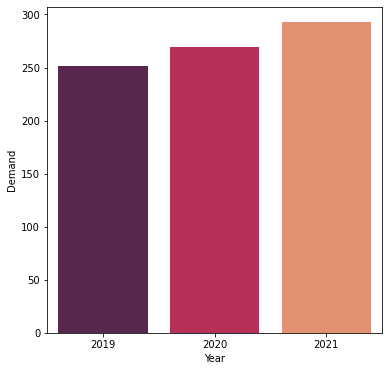

In [1168]:
dfInvGrouped = dfInv.groupby('Year').agg({'Demand':'mean'})

palette = sns.color_palette('rocket', 3)
plt.figure(figsize=(6,6))
sns.barplot(data=dfInvGrouped, x=dfInvGrouped.index, y='Demand', palette=palette)
plt.show()

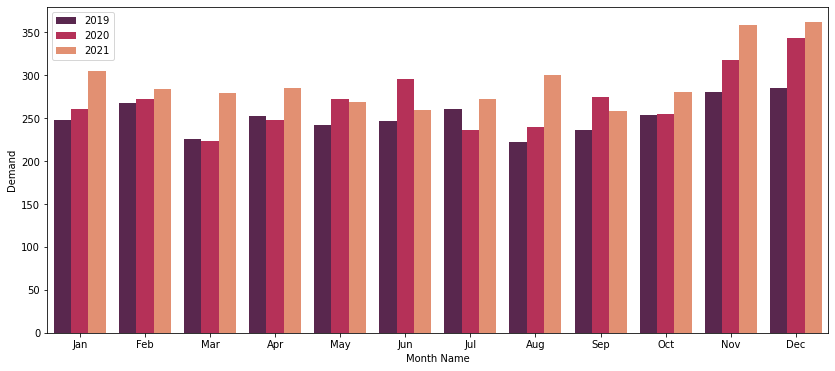

In [1169]:
dfInvGrouped = dfInv.groupby(['Year','Month']).agg({'Demand':'mean', 'Month Name':'first'}).reset_index()

palette = sns.color_palette('rocket', 3)
plt.figure(figsize=(14,6))
sns.barplot(data=dfInvGrouped, x=dfInvGrouped['Month Name'], y='Demand', palette=palette, hue='Year')
plt.legend(loc='upper left')
plt.show()

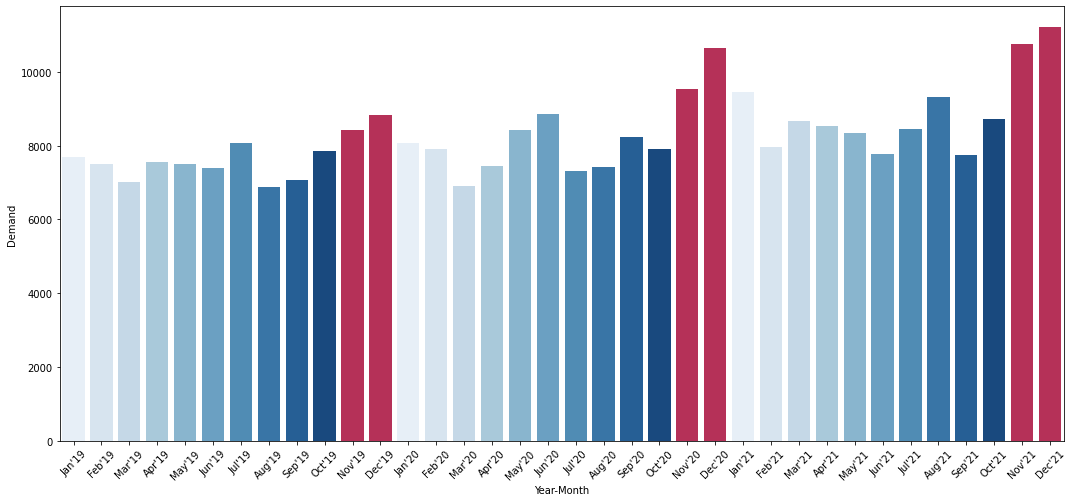

In [1170]:
dfInvGrouped = dfInv.groupby('Year-Month').agg({'Demand':'sum', 'Year':'mean', 'Year-Month Order':'mean'}).sort_values(by='Year-Month Order')

palette = sns.color_palette('Blues', 10)+sns.color_palette('rocket', 1)+sns.color_palette('rocket', 1)
plt.figure(figsize=(18,8))
sns.barplot(data=dfInvGrouped, x=dfInvGrouped.index, y='Demand', palette=palette)
plt.xticks(rotation=45)
plt.show()

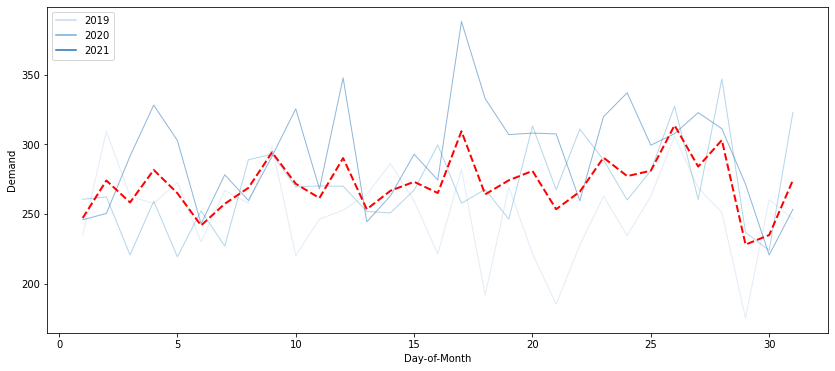

In [1171]:
dfInvGrouped = dfInv.groupby(['Year','Day-of-Month']).agg({'Demand':'mean'}).reset_index()
dfInvGrouped2 = dfInv.groupby('Day-of-Month').agg({'Demand':'mean'}).reset_index()

palette = sns.color_palette('Blues', 3)
plt.figure(figsize=(14,6))
sns.lineplot(data=dfInvGrouped, x=dfInvGrouped['Day-of-Month'], y='Demand', palette=palette, hue='Year', alpha=0.5, linewidth=1)
sns.lineplot(data=dfInvGrouped2, x=dfInvGrouped['Day-of-Month'], y='Demand', color='r', linestyle='--', linewidth=2)
plt.legend(loc='upper left')
plt.show()

In [1172]:
dfInv['Rolling 3D Demand'] = dfInv['Demand'].rolling(3).mean().fillna(method='bfill')
dfInv['Rolling 7D Demand'] = dfInv['Demand'].rolling(7).mean().fillna(method='bfill')
dfInv['Rolling 10D Demand'] = dfInv['Demand'].rolling(10).mean().fillna(method='bfill')
dfInv['Rolling 14D Demand'] = dfInv['Demand'].rolling(14).mean().fillna(method='bfill')
dfInv['Rolling 21D Demand'] = dfInv['Demand'].rolling(21).mean().fillna(method='bfill')
dfInv['Rolling 30D Demand'] = dfInv['Demand'].rolling(30).mean().fillna(method='bfill')

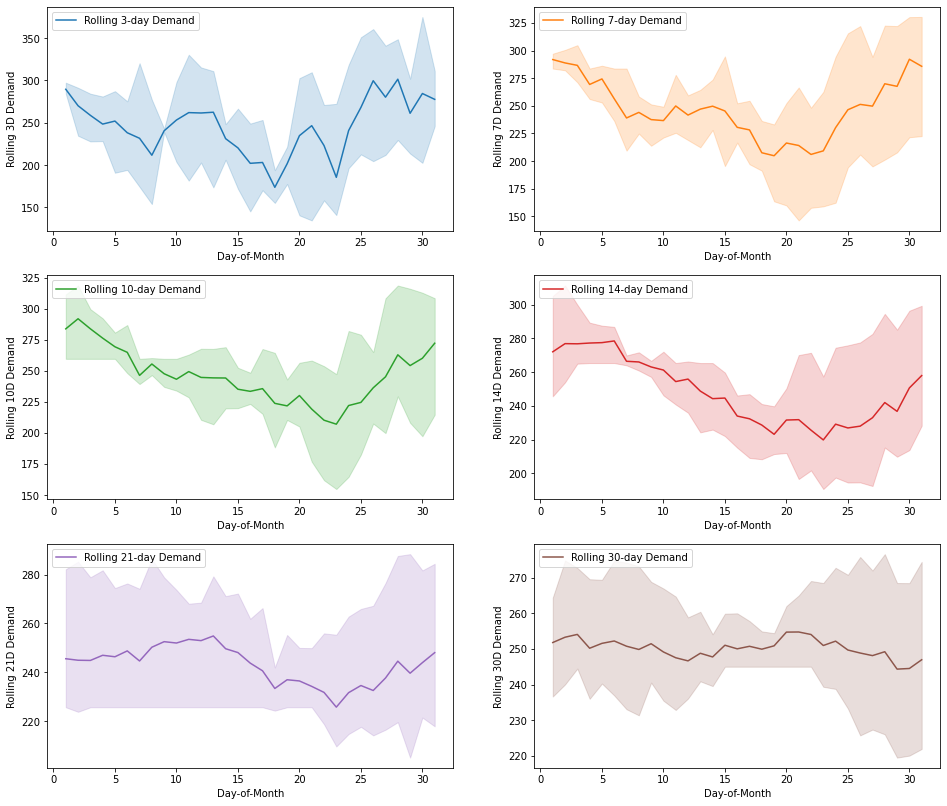

In [1173]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()
for i, d in enumerate([col for col in dfInv if 'Rolling' in col]):
  sns.lineplot(data=dfInv, x=dfInvGrouped['Day-of-Month'], y=d, ax=ax[i], label=d.replace('D ', '-day '), color=palette[i])
  ax[i].legend(loc='upper left')

plt.show()

# Identifying Current Inventory Policy

In [1174]:
dfInv2 = dfInv[['Day', 'Demand', 'Inventory', 'Day-of-Month', 'Month', 'Month Name', 'Year']].copy()
dfInv2.head()

,Day,Demand,Inventory,Day-of-Month,Month,Month Name,Year
0,2019-01-01,340,4660,1,1,Jan,2019
1,2019-01-02,336,4324,2,1,Jan,2019
2,2019-01-03,177,4147,3,1,Jan,2019
3,2019-01-04,172,3975,4,1,Jan,2019
4,2019-01-05,513,3462,5,1,Jan,2019


In [1175]:
dfInv2['Restock'] = np.nan

for i in dfInv2.index:

  if i>0:
    prev_end_inv = dfInv2.loc[(i-1),'Inventory']  # previous day's ending inventory
    end_inv = dfInv2.loc[i,'Inventory'] # current day's ending inventory
    demand = dfInv2.loc[i,'Demand'] # current day's demand

    start_inv = end_inv + demand # current day's starting inventory

    # if current day's starting inventory is greater than previous day's ending inventory, there was a restock, the quantity of which is the difference in the two
    if start_inv > prev_end_inv:
      dfInv2.loc[i,'Restock'] = start_inv - prev_end_inv 

dfInv2['Restock'].fillna(0, inplace=True)
dfInv2.head(15)

,Day,Demand,Inventory,Day-of-Month,Month,Month Name,Year,Restock
0,2019-01-01,340,4660,1,1,Jan,2019,0.0
1,2019-01-02,336,4324,2,1,Jan,2019,0.0
2,2019-01-03,177,4147,3,1,Jan,2019,0.0
3,2019-01-04,172,3975,4,1,Jan,2019,0.0
4,2019-01-05,513,3462,5,1,Jan,2019,0.0
5,2019-01-06,141,3321,6,1,Jan,2019,0.0
6,2019-01-07,307,3014,7,1,Jan,2019,0.0
7,2019-01-08,163,2851,8,1,Jan,2019,0.0
8,2019-01-09,259,2592,9,1,Jan,2019,0.0
9,2019-01-10,189,10553,10,1,Jan,2019,8150.0


In [1176]:
dfInv2[dfInv2['Restock']>0].groupby('Year')[['Restock']].count()

,Restock
Year,
2019,12
2020,12
2021,12


In [1177]:
dfInv2[dfInv2['Restock']>0].groupby('Month Name')[['Restock']].count()

,Restock
Month Name,
Apr,3
Aug,3
Dec,3
Feb,3
Jan,3
Jul,3
Jun,3
Mar,3
May,3


In [1178]:
dfInv2[dfInv2['Restock']>0].groupby('Day-of-Month')[['Restock']].count()

,Restock
Day-of-Month,
10,36


In [1179]:
dfInv2.pivot_table(values='Restock', index=['Year', 'Day-of-Month'], columns=['Month Name'])[dfInv2['Month Name'].unique()].fillna(0).astype('int64').head(15)

Month Name          Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct  \
Year Day-of-Month                                                               
2019 1                0     0     0     0     0     0     0     0     0     0   
     2                0     0     0     0     0     0     0     0     0     0   
     3                0     0     0     0     0     0     0     0     0     0   
     4                0     0     0     0     0     0     0     0     0     0   
     5                0     0     0     0     0     0     0     0     0     0   
     6                0     0     0     0     0     0     0     0     0     0   
     7                0     0     0     0     0     0     0     0     0     0   
     8                0     0     0     0     0     0     0     0     0     0   
     9                0     0     0     0     0     0     0     0     0     0   
     10            8150  8150  8150  8150  8150  8150  8150  8150  8150  8150   
     11               0     0     0     0     0     0     0     0     0     0   
     12               0     0     0     0     0     0     0     0     0     0   
     13               0     0     0     0     0     0     0     0     0     0   
     14               0     0     0     0     0     0     0     0     0     0   
     15               0     0     0     0     0     0     0     0     0     0   

Month Name          Nov   Dec  
Year Day-of-Month              
2019 1                0     0  
     2                0     0  
     3                0     0  
     4                0     0  
     5                0     0  
     6                0     0  
     7                0     0  
     8                0     0  
     9                0     0  
     10            8150  8150  
     11               0     0  
     12               0     0  
     13               0     0  
     14               0     0  
     15               0     0

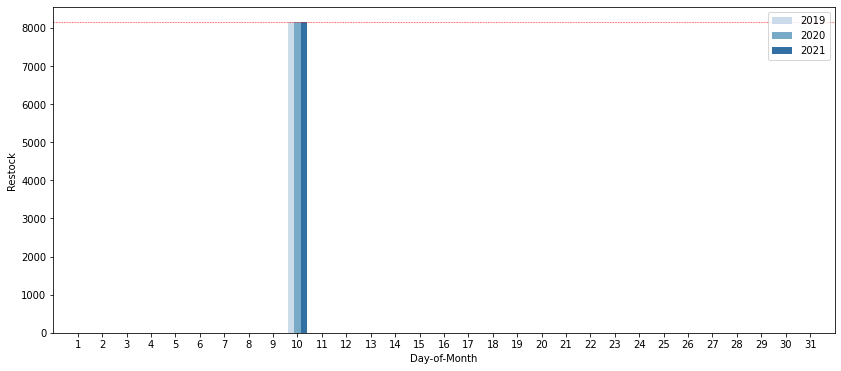

In [1180]:
palette = sns.color_palette('Blues', 3)
plt.figure(figsize=(14,6))
sns.barplot(data=dfInv2, x='Day-of-Month', y='Restock', hue='Year', palette=palette)
sns.lineplot(x=range(-2,32), y=8150, color='r', linewidth=0.5, linestyle='--')
plt.legend(loc='upper right')
plt.xlim(-1,31)
plt.show()

# Current Inventory Policy's Financial Assessment

## Years: 2019-2021

In [1181]:
dfInv3 = dfInv2.copy()
dfInv3['Sales Units'] = dfInv3['Demand']
dfInv3 = calculateFinancials(dfInv3)

dfInv3.head()

,Day,Demand,Inventory,Day-of-Month,Month,Month Name,Year,Restock,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2019-01-01,340,4660,1,1,Jan,2019,0.0,340,12070.0,0.0,1165.00,10905.00,1165.00
1,2019-01-02,336,4324,2,1,Jan,2019,0.0,336,11928.0,0.0,1081.00,10847.00,1081.00
2,2019-01-03,177,4147,3,1,Jan,2019,0.0,177,6283.5,0.0,1036.75,5246.75,1036.75
3,2019-01-04,172,3975,4,1,Jan,2019,0.0,172,6106.0,0.0,993.75,5112.25,993.75
4,2019-01-05,513,3462,5,1,Jan,2019,0.0,513,18211.5,0.0,865.50,17346.00,865.50


In [1182]:
dfF1 = reportFinancials(dfInv3)

########################### Sales Units ###########################
2019 Sales Units: 91742
2020 Sales Units: 98624
2021 Sales Units: 106856
------------------------- Total: 297222 -------------------------

############################# Revenue #############################
2019 Revenue: $3.257M
2020 Revenue: $3.501M
2021 Revenue: $3.793M
------------------------- Total: $10.551M -------------------------

######################### Ordering Costs ##########################
2019 Ordering Costs: $0.161M
2020 Ordering Costs: $0.161M
2021 Ordering Costs: $0.161M
------------------------- Total: $0.483M -------------------------

########################## Holding Costs ##########################
2019 Holding Costs: $0.957M
2020 Holding Costs: $1.313M
2021 Holding Costs: $0.832M
------------------------- Total: $3.102M -------------------------

############################# Profits #############################
2019 Profits: $2.139M
2020 Profits: $2.027M
2021 Profits: $2.801M
------------

In [1183]:
dfF1

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2019,91742,3256841.0,161100.0,956871.25,2138869.75,1117971.25
2020,98624,3501152.0,161100.0,1313014.25,2027037.75,1474114.25
2021,106856,3793388.0,161100.0,831750.00,2800538.00,992850.00


## Year: 2022

In [1184]:
dfInv2.head()

,Day,Demand,Inventory,Day-of-Month,Month,Month Name,Year,Restock
0,2019-01-01,340,4660,1,1,Jan,2019,0.0
1,2019-01-02,336,4324,2,1,Jan,2019,0.0
2,2019-01-03,177,4147,3,1,Jan,2019,0.0
3,2019-01-04,172,3975,4,1,Jan,2019,0.0
4,2019-01-05,513,3462,5,1,Jan,2019,0.0


In [1185]:
df22 = pd.DataFrame({'Day':pd.date_range(start='2022-01-01',end='2022-12-31')})

df22['Day-of-Month'] = df22['Day'].dt.day

df22['Month'] = df22['Day'].dt.month
df22['Month Name'] = df22['Day'].apply(lambda x: x.strftime('%b'))

df22['Year'] = df22['Day'].dt.year

df22.head()

,Day,Day-of-Month,Month,Month Name,Year
0,2022-01-01,1,1,Jan,2022
1,2022-01-02,2,1,Jan,2022
2,2022-01-03,3,1,Jan,2022
3,2022-01-04,4,1,Jan,2022
4,2022-01-05,5,1,Jan,2022


In [1186]:
df22 = demandForecast(df22)

prev_avg_demand = dfInv[dfInv['Year']==2021]['Demand'].mean()
estimated_avg_demand = df22['Demand'].mean()

difference = estimated_avg_demand - prev_avg_demand

while difference <= 10:
  df22 = demandForecast(df22)
  estimated_avg_demand = df22['Demand'].mean()
  difference = estimated_avg_demand - prev_avg_demand

df22.head()

,Day,Day-of-Month,Month,Month Name,Year,Demand
0,2022-01-01,1,1,Jan,2022,268
1,2022-01-02,2,1,Jan,2022,311
2,2022-01-03,3,1,Jan,2022,246
3,2022-01-04,4,1,Jan,2022,277
4,2022-01-05,5,1,Jan,2022,248


In [1187]:
df22['Inventory'] = 0
df22['Sales Units'] = 0
df22['Met Flag'] = 1

df22['Restock'] = df22['Day-of-Month'].apply(lambda x: 8150 if x == 10 else 0)

df22.head(11)

,Day,Day-of-Month,Month,Month Name,Year,Demand,Inventory,Sales Units,Met Flag,Restock
0,2022-01-01,1,1,Jan,2022,268,0,0,1,0
1,2022-01-02,2,1,Jan,2022,311,0,0,1,0
2,2022-01-03,3,1,Jan,2022,246,0,0,1,0
3,2022-01-04,4,1,Jan,2022,277,0,0,1,0
4,2022-01-05,5,1,Jan,2022,248,0,0,1,0
5,2022-01-06,6,1,Jan,2022,567,0,0,1,0
6,2022-01-07,7,1,Jan,2022,468,0,0,1,0
7,2022-01-08,8,1,Jan,2022,380,0,0,1,0
8,2022-01-09,9,1,Jan,2022,478,0,0,1,0
9,2022-01-10,10,1,Jan,2022,238,0,0,1,8150


In [1188]:
starting_inv = dfInv2[dfInv2['Day'] == '2021-12-31']['Inventory'].iloc[0]

for i in df22.index:
  starting_inv = starting_inv + df22.loc[i, 'Restock']
  demand = df22.loc[i,'Demand']
  leftover = starting_inv - demand
  if leftover >= 0:
    df22.loc[i,'Inventory'] = leftover
    df22.loc[i,'Sales Units'] = demand
    starting_inv = leftover
  else:
    df22.loc[i,'Met Flag'] = 0
    df22.loc[i,'Inventory'] = 0
    df22.loc[i,'Sales Units'] = starting_inv
    starting_inv = 0

df22.head(10)

,Day,Day-of-Month,Month,Month Name,Year,Demand,Inventory,Sales Units,Met Flag,Restock
0,2022-01-01,1,1,Jan,2022,268,910,268,1,0
1,2022-01-02,2,1,Jan,2022,311,599,311,1,0
2,2022-01-03,3,1,Jan,2022,246,353,246,1,0
3,2022-01-04,4,1,Jan,2022,277,76,277,1,0
4,2022-01-05,5,1,Jan,2022,248,0,76,0,0
5,2022-01-06,6,1,Jan,2022,567,0,0,0,0
6,2022-01-07,7,1,Jan,2022,468,0,0,0,0
7,2022-01-08,8,1,Jan,2022,380,0,0,0,0
8,2022-01-09,9,1,Jan,2022,478,0,0,0,0
9,2022-01-10,10,1,Jan,2022,238,7912,238,1,8150


In [1189]:
df22b = calculateFinancials(df22)
df22b.head()

,Day,Day-of-Month,Month,Month Name,Year,Demand,Inventory,Sales Units,Met Flag,Restock,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2022-01-01,1,1,Jan,2022,268,910,268,1,0,9514.0,0.0,227.50,9286.50,227.50
1,2022-01-02,2,1,Jan,2022,311,599,311,1,0,11040.5,0.0,149.75,10890.75,149.75
2,2022-01-03,3,1,Jan,2022,246,353,246,1,0,8733.0,0.0,88.25,8644.75,88.25
3,2022-01-04,4,1,Jan,2022,277,76,277,1,0,9833.5,0.0,19.00,9814.50,19.00
4,2022-01-05,5,1,Jan,2022,248,0,76,0,0,2698.0,0.0,0.00,2698.00,0.00


In [1190]:
dfF2 = reportFinancials(df22b)

########################### Sales Units ###########################
2022 Sales Units: 98506
------------------------- Total: 98506 -------------------------

############################# Revenue #############################
2022 Revenue: $3.497M
------------------------- Total: $3.497M -------------------------

######################### Ordering Costs ##########################
2022 Ordering Costs: $0.161M
------------------------- Total: $0.161M -------------------------

########################## Holding Costs ##########################
2022 Holding Costs: $0.326M
------------------------- Total: $0.326M -------------------------

############################# Profits #############################
2022 Profits: $3.010M
------------------------- Total: $3.010M -------------------------

########################### Total Costs ###########################
2022 Total Costs: $0.487M
------------------------- Total: $0.487M -------------------------



In [1191]:
dfF2

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2022,98506,3496963.0,161100.0,325686.0,3010177.0,486786.0


## Overall

In [1192]:
dfFa = pd.concat((dfF1, dfF2))
dfFa

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2019,91742,3256841.0,161100.0,956871.25,2138869.75,1117971.25
2020,98624,3501152.0,161100.0,1313014.25,2027037.75,1474114.25
2021,106856,3793388.0,161100.0,831750.00,2800538.00,992850.00
2022,98506,3496963.0,161100.0,325686.00,3010177.00,486786.00


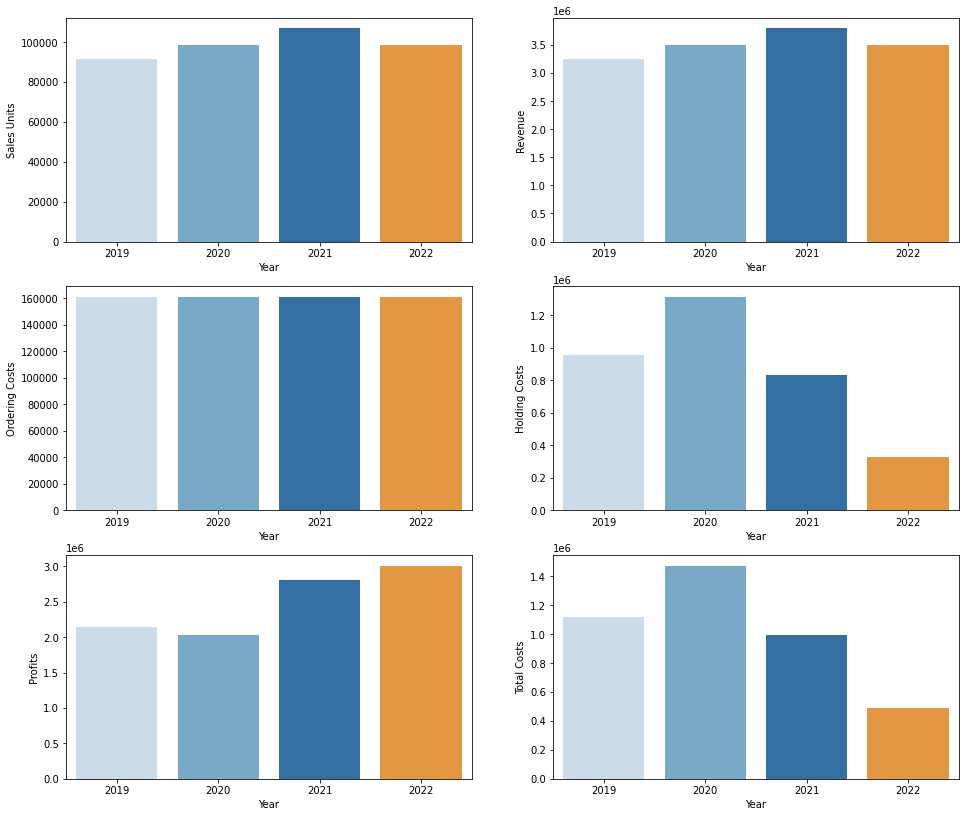

In [1193]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

palette = sns.color_palette('Blues', 3)+sns.color_palette('YlOrBr', 1)
ax = ax.ravel()
for i, info in enumerate(dfFa.columns):
  sns.barplot(data=dfFa, x=dfFa.index, y=info, palette=palette, ax=ax[i], label=info)

plt.show()

In [1194]:
dfTemp = df22.groupby('Met Flag').sum()
dfTemp['Unmet Demand'] = dfTemp['Demand'] - dfTemp['Sales Units']
dfTemp

,Day-of-Month,Month,Year,Demand,Inventory,Sales Units,Restock,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Unmet Demand
Met Flag,,,,,,,,,,,,,
0,342,291,84924,14481,0,1295,0,45972.5,0.0,0.0,45972.5,0.0,13186
1,5396,2091,653106,97211,1302744,97211,97800,3450990.5,161100.0,325686.0,2964204.5,486786.0,0


In [1195]:
print('Revenue lost from stockouts: $%.3fM' %(dfTemp[dfTemp.index == 0]['Unmet Demand'].iloc[0] * 35.5/1e6))

Revenue lost from stockouts: $0.468M


# EOQ Policy Implementation & Financial Assessment

## Years: 2019-2021

### Case I: Fixed EOQ for Each Year

In [1196]:
lead_time = 8
ed = dfInv3['Demand'].mean()
eoq = int(calculateEOQ(ed))
rop = int(np.round(ed*lead_time))

In [1197]:
info_dict = {'Year':dfInv3['Year'].unique(), 'EOQ':[eoq]*3, 'ROP':[rop]*3}
info = pd.DataFrame(info_dict)
info.set_index('Year', inplace=True)
info

,EOQ,ROP
Year,,
2019,1614,2170
2020,1614,2170
2021,1614,2170


In [1198]:
dfInv4 = dfInv3[['Day', 'Demand', 'Day-of-Month', 'Month', 'Month Name', 'Year']].copy()
dfInv4.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year
0,2019-01-01,340,1,1,Jan,2019
1,2019-01-02,336,2,1,Jan,2019
2,2019-01-03,177,3,1,Jan,2019
3,2019-01-04,172,4,1,Jan,2019
4,2019-01-05,513,5,1,Jan,2019


In [1199]:
dfInv4 = implementEOQ(info, dfInv4, starting_inv=5000, lead_time=8)
dfInv4.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units
0,2019-01-01,340,1,1,Jan,2019,4660,0,0,340
1,2019-01-02,336,2,1,Jan,2019,4324,0,0,336
2,2019-01-03,177,3,1,Jan,2019,4147,0,0,177
3,2019-01-04,172,4,1,Jan,2019,3975,0,0,172
4,2019-01-05,513,5,1,Jan,2019,3462,0,0,513


In [1200]:
calculateFinancials(dfInv4)
dfInv4.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2019-01-01,340,1,1,Jan,2019,4660,0,0,340,12070.0,0.0,1165.00,10905.00,1165.00
1,2019-01-02,336,2,1,Jan,2019,4324,0,0,336,11928.0,0.0,1081.00,10847.00,1081.00
2,2019-01-03,177,3,1,Jan,2019,4147,0,0,177,6283.5,0.0,1036.75,5246.75,1036.75
3,2019-01-04,172,4,1,Jan,2019,3975,0,0,172,6106.0,0.0,993.75,5112.25,993.75
4,2019-01-05,513,5,1,Jan,2019,3462,0,0,513,18211.5,0.0,865.50,17346.00,865.50


In [1201]:
dfF3 = reportFinancials(dfInv4)
dfF3

########################### Sales Units ###########################
2019 Sales Units: 67396
2020 Sales Units: 65539
2021 Sales Units: 65745
------------------------- Total: 198680 -------------------------

############################# Revenue #############################
2019 Revenue: $2.393M
2020 Revenue: $2.327M
2021 Revenue: $2.334M
------------------------- Total: $7.053M -------------------------

######################### Ordering Costs ##########################
2019 Ordering Costs: $0.141M
2020 Ordering Costs: $0.148M
2021 Ordering Costs: $0.145M
------------------------- Total: $0.435M -------------------------

########################## Holding Costs ##########################
2019 Holding Costs: $0.058M
2020 Holding Costs: $0.042M
2021 Holding Costs: $0.040M
------------------------- Total: $0.140M -------------------------

############################# Profits #############################
2019 Profits: $2.194M
2020 Profits: $2.136M
2021 Profits: $2.150M
--------------

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2019,67396,2392558.0,141219.0,57800.00,2193539.00,199019.00
2020,65539,2326634.5,148461.0,42125.25,2136048.25,190586.25
2021,65745,2333947.5,144840.0,39597.25,2149510.25,184437.25


### Case 2: Distinct EOQ for Each Year

In [1202]:
lead_time = 8

info = dfInv.groupby('Year')[['Demand']].mean()
info['EOQ'] = calculateEOQ(info['Demand']).astype('int64')
info['ROP'] = (info['Demand']*lead_time).astype('int64')
info

,Demand,EOQ,ROP
Year,,,
2019,251.347945,1553,2010
2020,269.464481,1608,2155
2021,292.756164,1676,2342


In [1203]:
dfInv5 = dfInv3[['Day', 'Demand', 'Day-of-Month', 'Month', 'Month Name', 'Year']].copy()
dfInv5.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year
0,2019-01-01,340,1,1,Jan,2019
1,2019-01-02,336,2,1,Jan,2019
2,2019-01-03,177,3,1,Jan,2019
3,2019-01-04,172,4,1,Jan,2019
4,2019-01-05,513,5,1,Jan,2019


In [1204]:
dfInv5 = implementEOQ(info, dfInv5, starting_inv=5000, lead_time=8)
dfInv5.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units
0,2019-01-01,340,1,1,Jan,2019,4660,0,0,340
1,2019-01-02,336,2,1,Jan,2019,4324,0,0,336
2,2019-01-03,177,3,1,Jan,2019,4147,0,0,177
3,2019-01-04,172,4,1,Jan,2019,3975,0,0,172
4,2019-01-05,513,5,1,Jan,2019,3462,0,0,513


In [1205]:
calculateFinancials(dfInv5)
dfInv5.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2019-01-01,340,1,1,Jan,2019,4660,0,0,340,12070.0,0.0,1165.00,10905.00,1165.00
1,2019-01-02,336,2,1,Jan,2019,4324,0,0,336,11928.0,0.0,1081.00,10847.00,1081.00
2,2019-01-03,177,3,1,Jan,2019,4147,0,0,177,6283.5,0.0,1036.75,5246.75,1036.75
3,2019-01-04,172,4,1,Jan,2019,3975,0,0,172,6106.0,0.0,993.75,5112.25,993.75
4,2019-01-05,513,5,1,Jan,2019,3462,0,0,513,18211.5,0.0,865.50,17346.00,865.50


In [1206]:
dfF4 = reportFinancials(dfInv5)
dfF4

########################### Sales Units ###########################
2019 Sales Units: 64851
2020 Sales Units: 65036
2021 Sales Units: 68716
------------------------- Total: 198603 -------------------------

############################# Revenue #############################
2019 Revenue: $2.302M
2020 Revenue: $2.309M
2021 Revenue: $2.439M
------------------------- Total: $7.050M -------------------------

######################### Ordering Costs ##########################
2019 Ordering Costs: $0.138M
2020 Ordering Costs: $0.144M
2021 Ordering Costs: $0.152M
------------------------- Total: $0.434M -------------------------

########################## Holding Costs ##########################
2019 Holding Costs: $0.052M
2020 Holding Costs: $0.042M
2021 Holding Costs: $0.042M
------------------------- Total: $0.136M -------------------------

############################# Profits #############################
2019 Profits: $2.113M
2020 Profits: $2.122M
2021 Profits: $2.245M
--------------

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2019,64851,2302210.5,137650.5,51636.25,2112923.75,189286.75
2020,65036,2308778.0,144480.0,42317.00,2121981.00,186797.00
2021,68716,2439418.0,152274.0,42294.75,2244849.25,194568.75


### Case I vs. Case II

In [1207]:
dfTemp1 = dfF3.copy()
dfTemp1['Type'] = 'Case I'

dfTemp2 = dfF4.copy()
dfTemp2['Type'] = 'Case II'

dfFb = pd.concat((dfTemp1, dfTemp2))
dfFb.reset_index(inplace=True)
dfFb

,Year,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Type
0,2019,67396,2392558.0,141219.0,57800.00,2193539.00,199019.00,Case I
1,2020,65539,2326634.5,148461.0,42125.25,2136048.25,190586.25,Case I
2,2021,65745,2333947.5,144840.0,39597.25,2149510.25,184437.25,Case I
3,2019,64851,2302210.5,137650.5,51636.25,2112923.75,189286.75,Case II
4,2020,65036,2308778.0,144480.0,42317.00,2121981.00,186797.00,Case II
5,2021,68716,2439418.0,152274.0,42294.75,2244849.25,194568.75,Case II


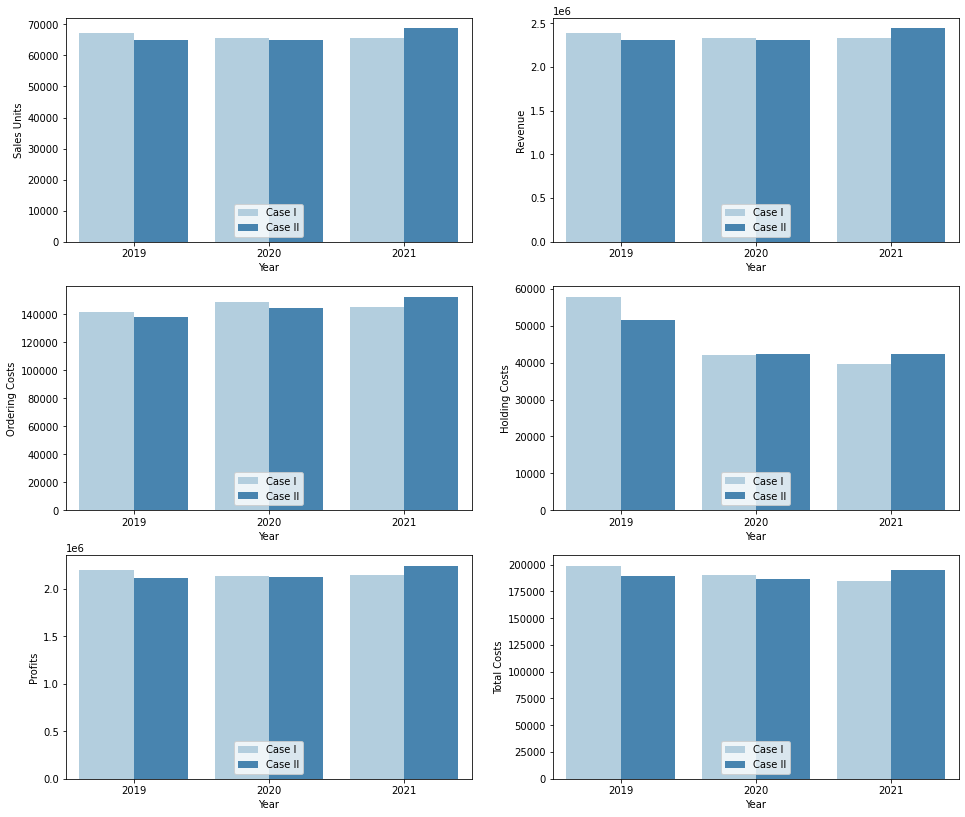

In [1208]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

ax = ax.ravel()
for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Type')]):
  sns.barplot(data=dfFb, x='Year', y=info, hue='Type', palette='Blues', ax=ax[i])
  ax[i].legend(loc='lower center')

plt.show()

## Years: 2022

In [1209]:
lead_time = 8

info = df22.groupby('Year')[['Demand']].mean()
info['EOQ'] = calculateEOQ(info['Demand']).astype('int64')
info['ROP'] = (info['Demand']*lead_time).astype('int64')
info

,Demand,EOQ,ROP
Year,,,
2022,306.005479,1714,2448


In [1210]:
df22c = df22[['Day', 'Demand', 'Day-of-Month', 'Month', 'Month Name', 'Year']].copy()
df22c.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year
0,2022-01-01,268,1,1,Jan,2022
1,2022-01-02,311,2,1,Jan,2022
2,2022-01-03,246,3,1,Jan,2022
3,2022-01-04,277,4,1,Jan,2022
4,2022-01-05,248,5,1,Jan,2022


In [1211]:
df22c = implementEOQ(info, df22c, starting_inv=5000, lead_time=8)
df22c.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units
0,2022-01-01,268,1,1,Jan,2022,4732,0,0,268
1,2022-01-02,311,2,1,Jan,2022,4421,0,0,311
2,2022-01-03,246,3,1,Jan,2022,4175,0,0,246
3,2022-01-04,277,4,1,Jan,2022,3898,0,0,277
4,2022-01-05,248,5,1,Jan,2022,3650,0,0,248


In [1212]:
calculateFinancials(df22c)
df22c.head()

,Day,Demand,Day-of-Month,Month,Month Name,Year,Inventory,Restock Flag,Restock,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2022-01-01,268,1,1,Jan,2022,4732,0,0,268,9514.0,0.0,1183.00,8331.00,1183.00
1,2022-01-02,311,2,1,Jan,2022,4421,0,0,311,11040.5,0.0,1105.25,9935.25,1105.25
2,2022-01-03,246,3,1,Jan,2022,4175,0,0,246,8733.0,0.0,1043.75,7689.25,1043.75
3,2022-01-04,277,4,1,Jan,2022,3898,0,0,277,9833.5,0.0,974.50,8859.00,974.50
4,2022-01-05,248,5,1,Jan,2022,3650,0,0,248,8804.0,0.0,912.50,7891.50,912.50


In [1213]:
dfF5 = reportFinancials(df22c)
dfF5

########################### Sales Units ###########################
2022 Sales Units: 71846
------------------------- Total: 71846 -------------------------

############################# Revenue #############################
2022 Revenue: $2.551M
------------------------- Total: $2.551M -------------------------

######################### Ordering Costs ##########################
2022 Ordering Costs: $0.147M
------------------------- Total: $0.147M -------------------------

########################## Holding Costs ##########################
2022 Holding Costs: $0.050M
------------------------- Total: $0.050M -------------------------

############################# Profits #############################
2022 Profits: $2.353M
------------------------- Total: $2.353M -------------------------

########################### Total Costs ###########################
2022 Total Costs: $0.197M
------------------------- Total: $0.197M -------------------------



,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2022,71846,2550533.0,147069.0,50264.5,2353199.5,197333.5


## Overall

In [1214]:
dfFc = pd.concat((dfF4, dfF5))
dfFc

,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
Year,,,,,,
2019,64851,2302210.5,137650.5,51636.25,2112923.75,189286.75
2020,65036,2308778.0,144480.0,42317.00,2121981.00,186797.00
2021,68716,2439418.0,152274.0,42294.75,2244849.25,194568.75
2022,71846,2550533.0,147069.0,50264.50,2353199.50,197333.50


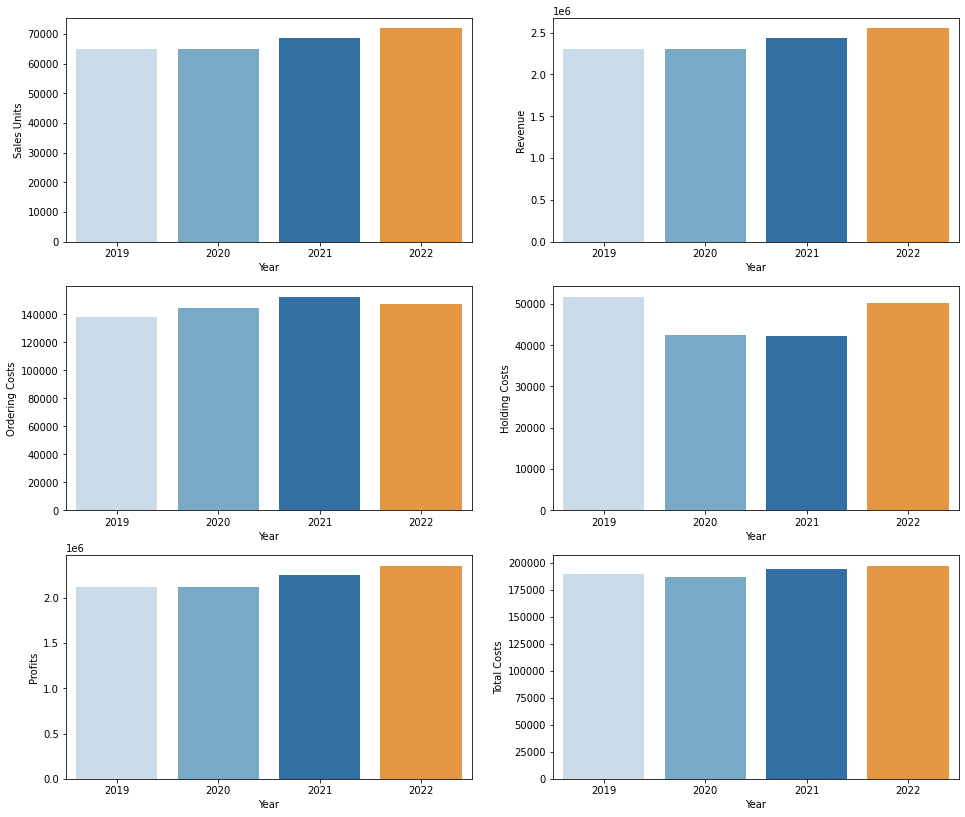

In [1215]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

palette = sns.color_palette('Blues', 3)+sns.color_palette('YlOrBr', 1)
ax = ax.ravel()
for i, info in enumerate(dfFc.columns):
  sns.barplot(data=dfFc, x=dfFc.index, y=info, palette=palette, ax=ax[i], label=info)

plt.show()

# Current Policy vs. EOQ Policy

In [1216]:
dfTemp1 = dfFa.copy()
dfTemp1['Policy'] = 'Current'

dfTemp2 = dfFc.copy()
dfTemp2['Policy'] = 'EOQ'

dfFb = pd.concat((dfTemp1, dfTemp2))
dfFb.reset_index(inplace=True)
dfFb

,Year,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Policy
0,2019,91742,3256841.0,161100.0,956871.25,2138869.75,1117971.25,Current
1,2020,98624,3501152.0,161100.0,1313014.25,2027037.75,1474114.25,Current
2,2021,106856,3793388.0,161100.0,831750.00,2800538.00,992850.00,Current
3,2022,98506,3496963.0,161100.0,325686.00,3010177.00,486786.00,Current
4,2019,64851,2302210.5,137650.5,51636.25,2112923.75,189286.75,EOQ
5,2020,65036,2308778.0,144480.0,42317.00,2121981.00,186797.00,EOQ
6,2021,68716,2439418.0,152274.0,42294.75,2244849.25,194568.75,EOQ
7,2022,71846,2550533.0,147069.0,50264.50,2353199.50,197333.50,EOQ


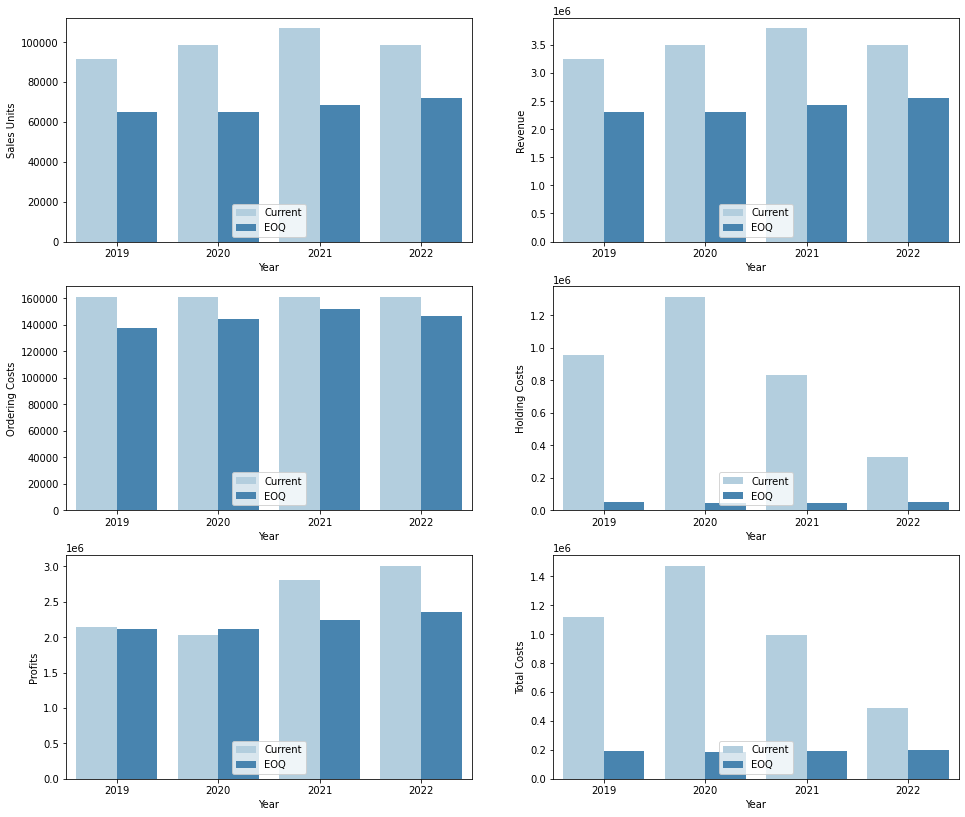

In [1217]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

ax = ax.ravel()
for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.barplot(data=dfFb, x='Year', y=info, hue='Policy', palette='Blues', ax=ax[i])
  ax[i].legend(loc='lower center')

plt.show()

In [1218]:
dfTemp1['Years'] = np.where(dfTemp1.index < 2022, '2019-2021', '2022')
dfTemp1 = dfTemp1.groupby('Years').sum()
dfTemp1['Policy'] = 'Current'

dfTemp2['Years'] = np.where(dfTemp2.index < 2022, '2019-2021', '2022')
dfTemp2 = dfTemp2.groupby('Years').sum()
dfTemp2['Policy'] = 'EOQ'

dfFc = pd.concat((dfTemp1, dfTemp2))
dfFc.reset_index(inplace=True)
dfFc

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Policy
0,2019-2021,297222,10551381.0,483300.0,3101635.5,6966445.5,3584935.5,Current
1,2022,98506,3496963.0,161100.0,325686.0,3010177.0,486786.0,Current
2,2019-2021,198603,7050406.5,434404.5,136248.0,6479754.0,570652.5,EOQ
3,2022,71846,2550533.0,147069.0,50264.5,2353199.5,197333.5,EOQ


In [1219]:
{col: 'sum' for col in dfFc.columns if (col != 'Policy')}

{'Holding Costs': 'sum',
 'Ordering Costs': 'sum',
 'Profits': 'sum',
 'Revenue': 'sum',
 'Sales Units': 'sum',
 'Total Costs': 'sum',
 'Years': 'sum'}

In [1220]:
dfTemp3 = dfFc.groupby('Policy').agg({'Holding Costs': 'sum',
 'Ordering Costs': 'sum',
 'Profits': 'sum',
 'Revenue': 'sum',
 'Sales Units': 'sum',
 'Total Costs': 'sum',
 'Years':'first'})

dfTemp3['Years'] = 'Combined'
dfTemp3.reset_index(inplace=True)

dfFd = pd.concat((dfFc, dfTemp3))

In [1221]:
dfFd.sort_values(by=['Years', 'Policy'], inplace=True)
dfFd

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Policy
0,2019-2021,297222,10551381.0,483300.0,3101635.5,6966445.5,3584935.5,Current
2,2019-2021,198603,7050406.5,434404.5,136248.0,6479754.0,570652.5,EOQ
1,2022,98506,3496963.0,161100.0,325686.0,3010177.0,486786.0,Current
3,2022,71846,2550533.0,147069.0,50264.5,2353199.5,197333.5,EOQ
0,Combined,395728,14048344.0,644400.0,3427321.5,9976622.5,4071721.5,Current
1,Combined,270449,9600939.5,581473.5,186512.5,8832953.5,767986.0,EOQ


In [1222]:
dfFd

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Policy
0,2019-2021,297222,10551381.0,483300.0,3101635.5,6966445.5,3584935.5,Current
2,2019-2021,198603,7050406.5,434404.5,136248.0,6479754.0,570652.5,EOQ
1,2022,98506,3496963.0,161100.0,325686.0,3010177.0,486786.0,Current
3,2022,71846,2550533.0,147069.0,50264.5,2353199.5,197333.5,EOQ
0,Combined,395728,14048344.0,644400.0,3427321.5,9976622.5,4071721.5,Current
1,Combined,270449,9600939.5,581473.5,186512.5,8832953.5,767986.0,EOQ


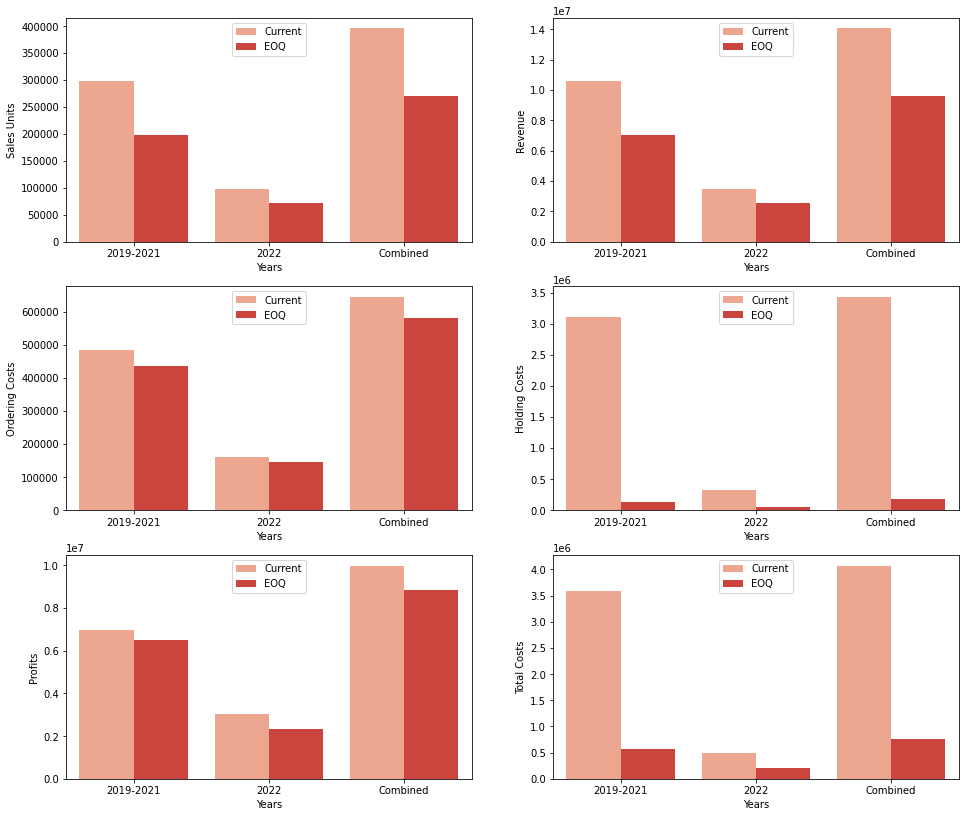

In [1223]:
fig, ax = plt.subplots(3,2, figsize=(16,14))

ax = ax.ravel()
for i, info in enumerate([col for col in dfFd.columns if col not in ('Years', 'Policy')]):
  sns.barplot(data=dfFd, x='Years', y=info, hue='Policy', palette='Reds', ax=ax[i])
  ax[i].legend(loc='upper center')

plt.show()

# EOQ Policy: Trade-offs Based on Stockout Risks

In [1343]:
def tradeoffEOQ(df, forecast_df, lead_time=8, alpha=0.95):
  """
  Returns financials for existing and forecasted data using EOQ policy, deriving ROP based on the specified level of alpha (service level).
  
  args:
  df: existing data
  forecast_df: forecast data
  lead_time: number of days that it takes for the order to arrive
  alpha: service level
  """

  cols = ['Day', 'Demand', 'Day-of-Month', 'Month', 'Month Name', 'Year']

  dfTemp = pd.concat((df[cols], forecast_df[cols])).reset_index(drop=True)

  info = dfTemp.groupby('Year')[['Demand']].mean()
  info['EOQ'] = calculateEOQ(info['Demand']).astype('int64')

  for year in info.index:
    rop = nbinom.ppf(n=5*lead_time, p=0.02, q=alpha) + np.round((70*(30+31)/365)*lead_time) + (year-2019)*10*lead_time
    info.loc[year, 'ROP'] = rop

  dfTemp = implementEOQ(info, dfTemp, starting_inv=5000, lead_time=lead_time)
  calculateFinancials(dfTemp)

  dfReturn = reportFinancials(dfTemp, show=False)
  dfReturn['Years'] = np.where(dfReturn.index < 2022, '2019-2021', '2022')
  dfReturn = dfReturn.groupby('Years').sum()
  
  return dfReturn.reset_index()

In [1344]:
tradeoffEOQ(dfInv, df22, alpha=0.99)

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2019-2021,198535,7047992.5,434302.5,139923.50,6473766.50,574226.00
1,2022,70274,2494727.0,154611.0,43354.25,2296761.75,197965.25


In [1150]:
results = pd.DataFrame({'Years': [],
                        'Sales Units': [],
                        'Revenue': [],
                        'Ordering Costs': [],
                        'Holding Costs': [],
                        'Profits': [],
                        'Total Costs': [],
                        'Risk': [],
                        })

alpha_list = np.concatenate((np.arange(0.5, 0.9, 0.05), np.arange(0.9, 0.99, 0.01)))

for service_level in alpha_list:
  df = tradeoffEOQ(dfInv, df22, alpha=service_level)
  df['Risk'] = np.round((1-service_level),3)
  results = pd.concat((results, df))

In [1151]:
results.reset_index(drop=True, inplace=True)
results.sort_values(by=['Risk', 'Years'], ascending=[False, True], inplace=True)
results.head(10)

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Risk
0,2019-2021,198535.0,7047992.5,434302.5,138886.5,6474803.5,573189.0,0.50
1,2022,68861.0,2444565.5,154242.0,43150.5,2247173.0,197392.5,0.50
2,2019-2021,198535.0,7047992.5,434302.5,138886.5,6474803.5,573189.0,0.45
3,2022,68861.0,2444565.5,154242.0,43150.5,2247173.0,197392.5,0.45
4,2019-2021,198535.0,7047992.5,434302.5,138886.5,6474803.5,573189.0,0.40
5,2022,68861.0,2444565.5,154242.0,43150.5,2247173.0,197392.5,0.40
6,2019-2021,198535.0,7047992.5,434302.5,138886.5,6474803.5,573189.0,0.35
7,2022,68861.0,2444565.5,154242.0,43150.5,2247173.0,197392.5,0.35
8,2019-2021,198535.0,7047992.5,434302.5,138886.5,6474803.5,573189.0,0.30
9,2022,68861.0,2444565.5,154242.0,43150.5,2247173.0,197392.5,0.30


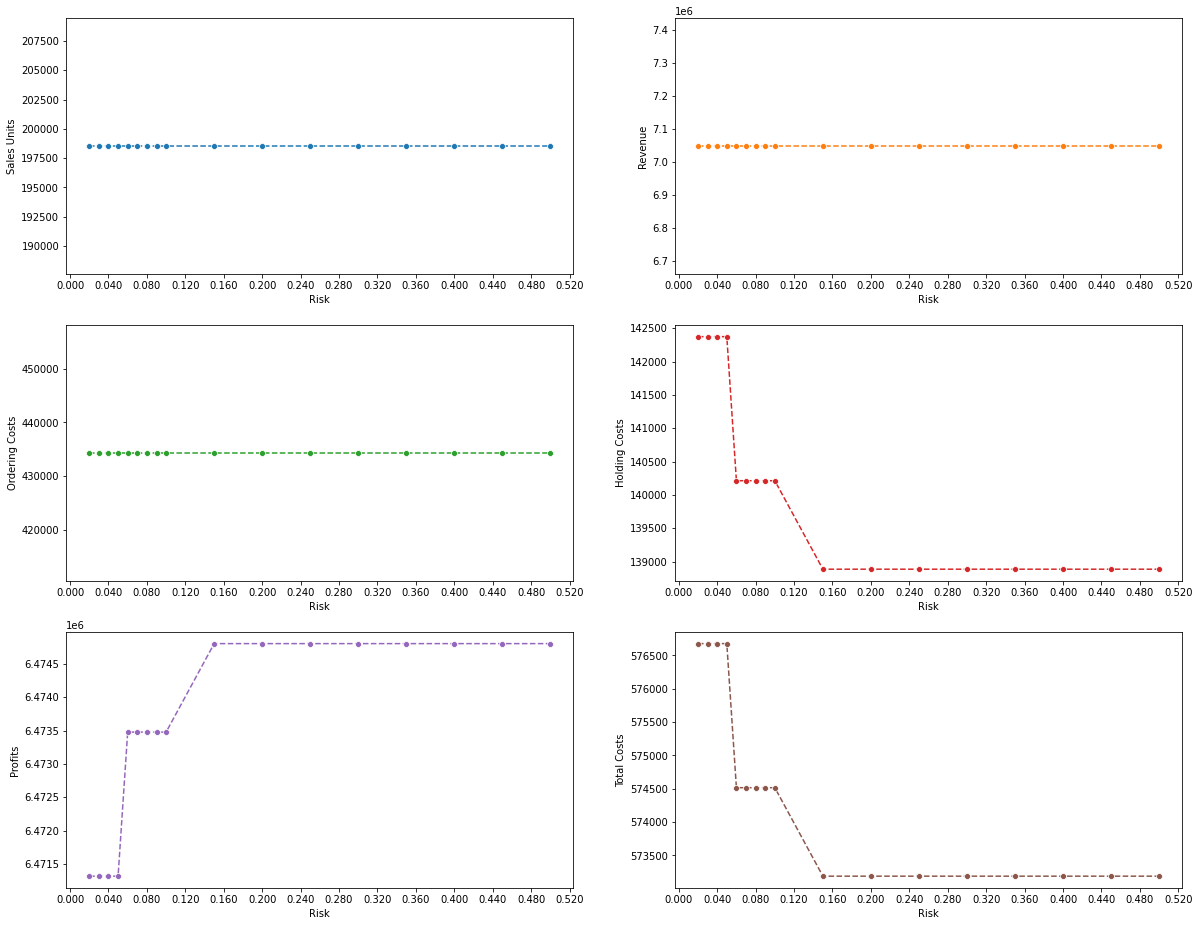

In [1226]:
fig, ax = plt.subplots(3,2, figsize=(20,16))

filtered = results[results['Years']=='2019-2021']

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()

for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.lineplot(data=filtered, x='Risk', y=info, marker='o', palette='Blues', ax=ax[i], color=palette[i], linestyle='--')
  ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
  ax[i].xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

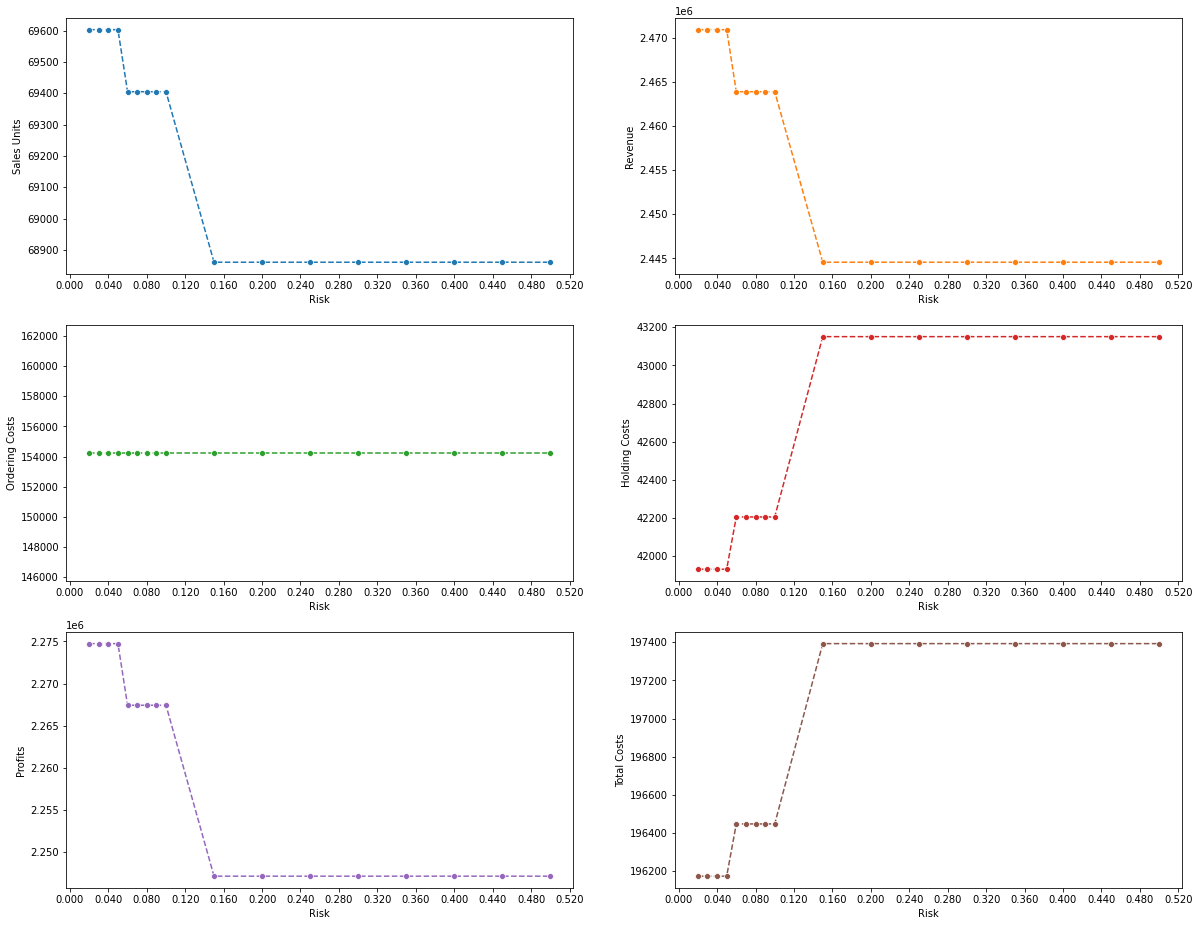

In [1227]:
fig, ax = plt.subplots(3,2, figsize=(20,16))

filtered = results[results['Years']=='2022']

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()

for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.lineplot(data=filtered, x='Risk', y=info, marker='o', palette='Blues', ax=ax[i], color=palette[i], linestyle='--')
  ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
  ax[i].xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

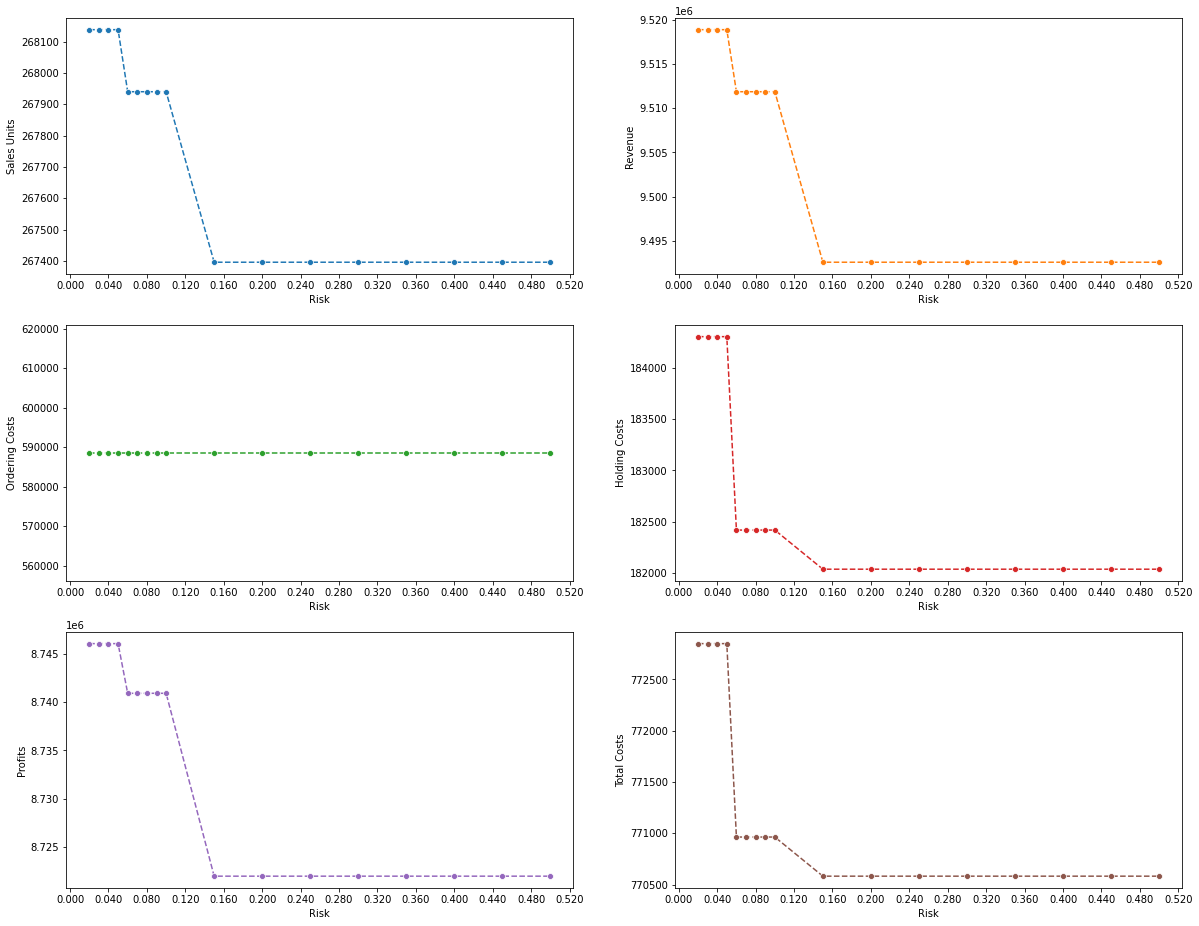

In [1228]:
fig, ax = plt.subplots(3,2, figsize=(20,16))

filtered = results.groupby('Risk').sum().reset_index()

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()

for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.lineplot(data=filtered, x='Risk', y=info, marker='o', palette='Blues', ax=ax[i], color=palette[i], linestyle='--')
  ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
  ax[i].xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

In [1155]:
results[results['Years']=='2019-2021']['Profits'].max() - results[results['Years']=='2019-2021']['Profits'].min()

3487.25

In [1156]:
results[results['Years']=='2022']['Profits'].max() - results[results['Years']=='2022']['Profits'].min()

27559.75

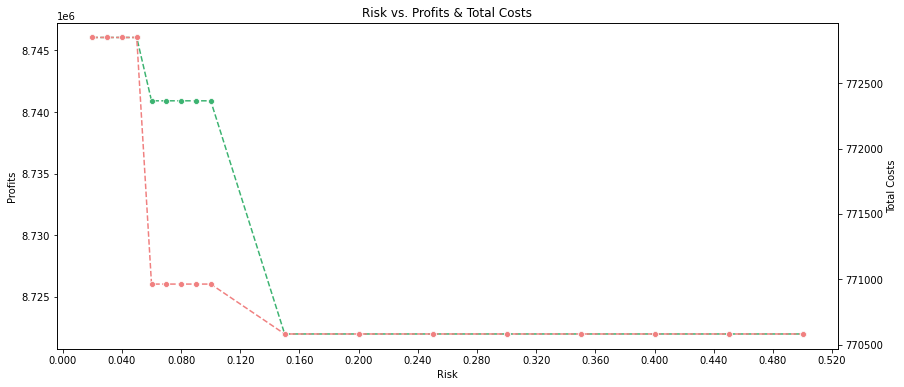

In [1245]:
plt.figure(figsize=(14,6))

filtered = results.groupby('Risk').sum().reset_index()

sns.lineplot(data=filtered, x='Risk', y='Profits', marker='o', color='mediumseagreen', linestyle='--')

ax = plt.twinx()
sns.lineplot(data=filtered, x='Risk', y='Total Costs', marker='o', color='lightcoral', ax=ax, linestyle='--')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.title('Risk vs. Profits & Total Costs')
plt.show()

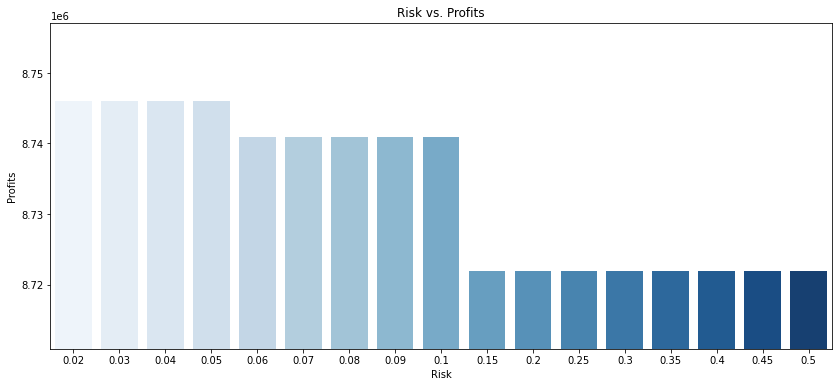

In [1249]:
plt.figure(figsize=(14,6))

filtered = results.groupby('Risk').sum().reset_index()
info = 'Profits'

sns.barplot(data=filtered, x='Risk', y=info, palette='Blues')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Risk vs. {}'.format(info))
plt.show()

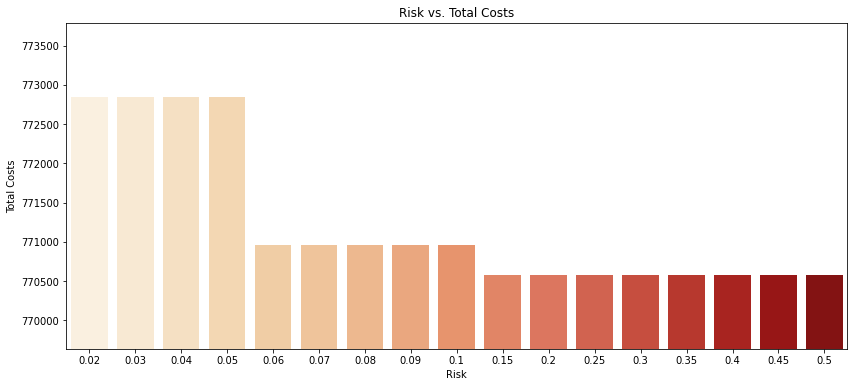

In [1248]:
plt.figure(figsize=(14,6))

filtered = results.groupby('Risk').sum().reset_index()
info = 'Total Costs'

sns.barplot(data=filtered, x='Risk', y=info, palette='OrRd')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Risk vs. {}'.format(info))
plt.show()

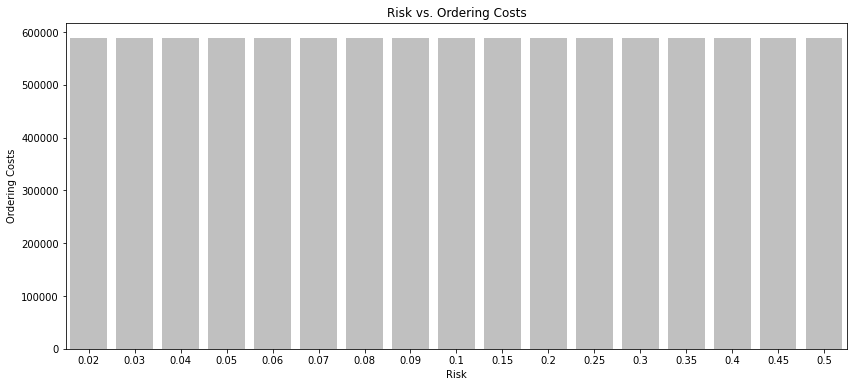

In [1259]:
plt.figure(figsize=(14,6))

filtered = results.groupby('Risk').sum().reset_index()
info = 'Ordering Costs'

sns.barplot(data=filtered, x='Risk', y=info, color='silver')

plt.title('Risk vs. {}'.format(info))
plt.show()

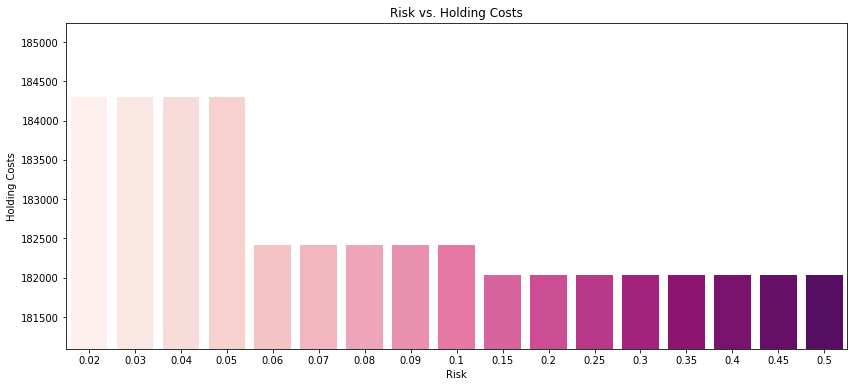

In [1251]:
plt.figure(figsize=(14,6))

filtered = results.groupby('Risk').sum().reset_index()
info = 'Holding Costs'

sns.barplot(data=filtered, x='Risk', y=info, palette='RdPu')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Risk vs. {}'.format(info))
plt.show()

# Improved Model

In [1341]:
def tradeoffReorder(df, forecast_df, lead_time=8, alpha=0.95, reorder_adj=0, rop_adj=0):
  """
  Returns financials for existing and forecasted data using an updated and improved policy based on a more flexible reorder quantity.
  
  args:
  df: existing data
  forecast_df: forecast data
  lead_time: number of days that it takes for the order to arrive
  alpha: service level
  """

  cols = ['Day', 'Demand', 'Day-of-Month', 'Month', 'Month Name', 'Year']

  dfTemp = pd.concat((df[cols], forecast_df[cols])).reset_index(drop=True)
  info_dict = {'Year':dfTemp['Year'].unique()}

  info = pd.DataFrame(info_dict).set_index('Year')

  base = np.round(nbinom.stats(5, 0.02, moments='m'))
  seasonal = np.round((70*(30+31)/365))
  info['Expected Demand'] = base + seasonal + (info.index-2019)*10

  info['Reorder'] = info['Expected Demand']*lead_time*(1+reorder_adj)

  for year in info.index:
    rop = nbinom.ppf(n=5*lead_time, p=0.02, q=alpha) + np.round((70*(30+31)/365)*lead_time) + (year-2019)*10*lead_time
    info.loc[year, 'ROP'] = rop*(1+rop_adj)

  dfTemp = implementEOQ(info, dfTemp, starting_inv=5000, lead_time=lead_time, method='Reorder')
  calculateFinancials(dfTemp)

  dfReturn = reportFinancials(dfTemp, show=False)
  dfReturn['Years'] = np.where(dfReturn.index < 2022, '2019-2021', '2022')
  dfReturn = dfReturn.groupby('Years').sum()
  
  return dfReturn.reset_index()

In [1342]:
tradeoffReorder(dfInv, df22, reorder_adj=0, rop_adj=0)

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs
0,2019-2021,261400,9279700.0,528600.0,257392.25,8493707.75,785992.25
1,2022,92811,3294790.5,190404.0,81934.50,3022452.00,272338.50


In [1287]:
results = pd.DataFrame({'Years': [],
                        'Sales Units': [],
                        'Revenue': [],
                        'Ordering Costs': [],
                        'Holding Costs': [],
                        'Profits': [],
                        'Total Costs': []
                        })

adj_list = np.arange(-0.25, 0.5, 0.05)

for reorder_adj in adj_list:
  for rop_adj in adj_list:
    df = tradeoffReorder(dfInv, df22, reorder_adj=reorder_adj, rop_adj=rop_adj)
    df['Reorder Proportion'] = np.round((1+reorder_adj),3)
    df['ROP Proportion Shift'] = np.round((1+rop_adj),3)
    results = pd.concat((results, df))

In [1294]:
results.reset_index(drop=True, inplace=True)
results.sort_values(by=['Reorder Proportion', 'ROP Proportion Shift', 'Years'], ascending=True, inplace=True)
results.head(10)

,Years,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,Reorder Proportion,ROP Proportion Shift
0,2019-2021,197360.0,7006280.0,432540.0,134548.00,6439192.00,567088.00,0.75,0.75
367,2022,69143.0,2454576.5,155103.0,42183.75,2257289.75,197286.75,0.75,0.75
143,2019-2021,197300.0,7004150.0,432450.0,137154.50,6434545.50,569604.50,0.75,0.80
368,2022,69661.0,2472965.5,155103.0,41505.50,2276357.00,196608.50,0.75,0.80
144,2019-2021,197300.0,7004150.0,432450.0,137154.50,6434545.50,569604.50,0.75,0.85
369,2022,69661.0,2472965.5,155103.0,41505.50,2276357.00,196608.50,0.75,0.85
145,2019-2021,197300.0,7004150.0,432450.0,137154.50,6434545.50,569604.50,0.75,0.90
370,2022,69661.0,2472965.5,155103.0,41505.50,2276357.00,196608.50,0.75,0.90
146,2019-2021,197300.0,7004150.0,432450.0,138475.75,6433224.25,570925.75,0.75,0.95
371,2022,69851.0,2479710.5,155103.0,42528.50,2282079.00,197631.50,0.75,0.95


In [1322]:
agg = results.groupby(['Reorder Proportion', 'ROP Proportion Shift']).sum().reset_index()

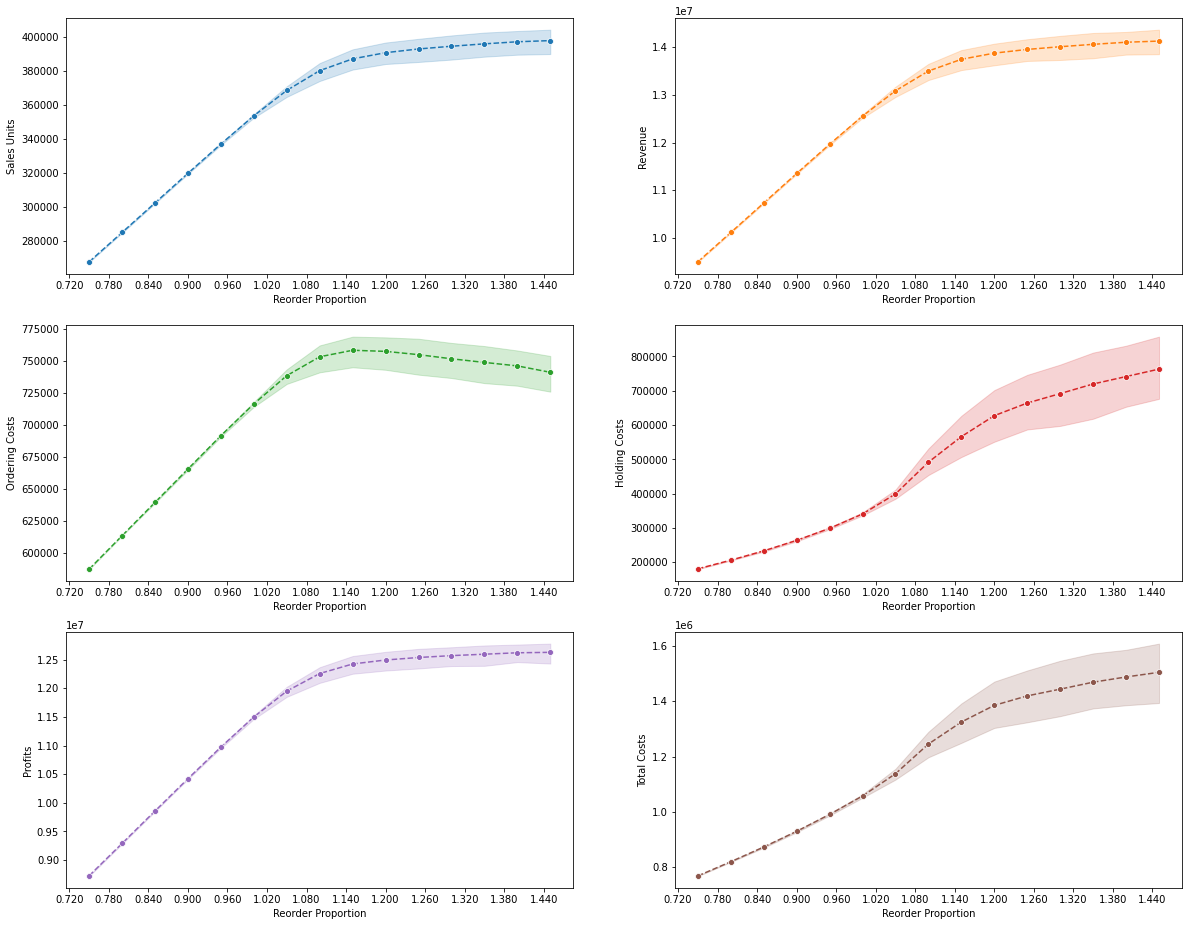

In [1298]:
fig, ax = plt.subplots(3,2, figsize=(20,16))

factor = 'Reorder Proportion'

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()

for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.lineplot(data=agg, x=factor, y=info, marker='o', palette='Blues', ax=ax[i], color=palette[i], linestyle='--')
  ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
  ax[i].xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

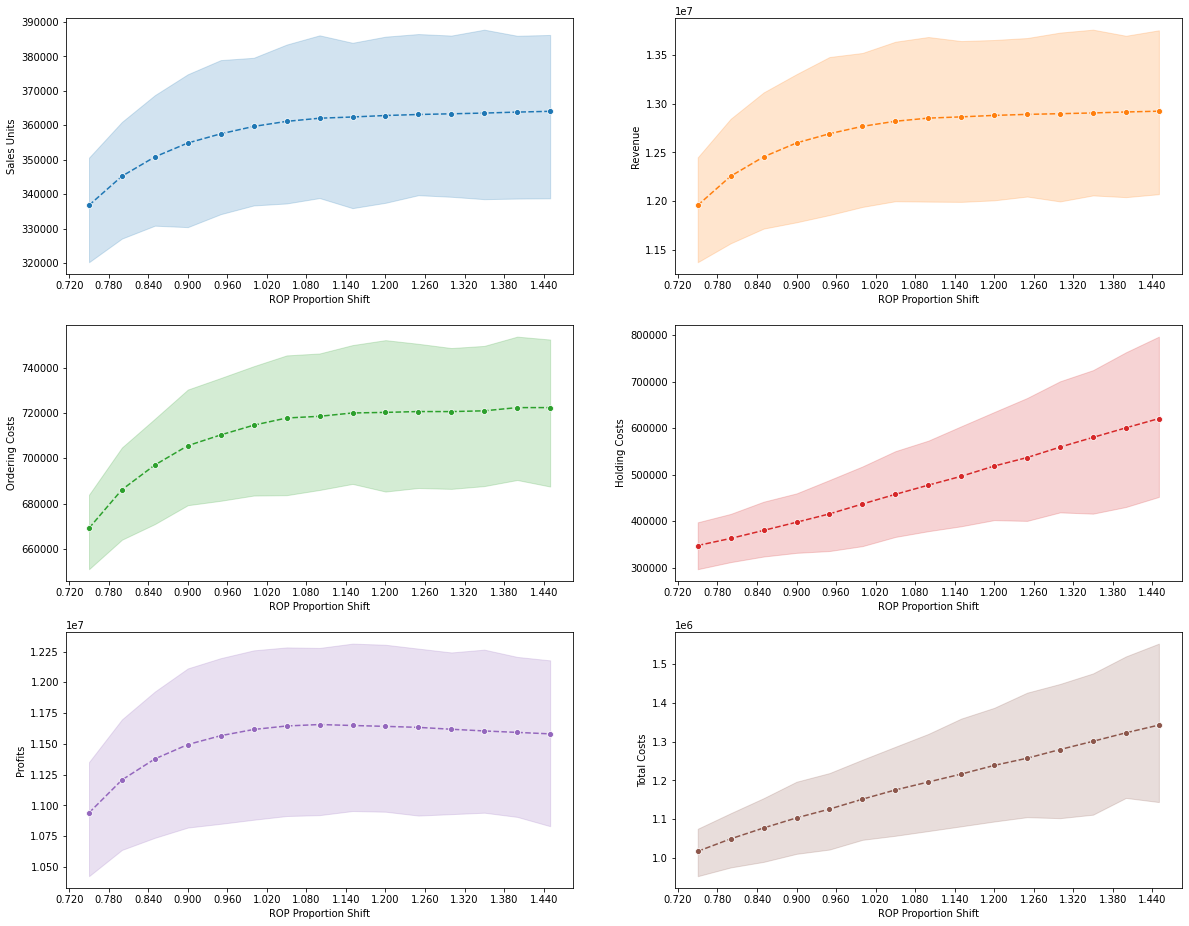

In [1299]:
fig, ax = plt.subplots(3,2, figsize=(20,16))

factor = 'ROP Proportion Shift'

palette = sns.color_palette('tab10', 6)
ax = ax.ravel()

for i, info in enumerate([col for col in dfFb.columns if col not in ('Year', 'Policy')]):
  sns.lineplot(data=agg, x=factor, y=info, marker='o', palette='Blues', ax=ax[i], color=palette[i], linestyle='--')
  ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
  ax[i].xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

In [1325]:
agg['Reoder, ROP Proportions'] = agg.apply(lambda row: str(row['Reorder Proportion']) + ', ' + str(row['ROP Proportion Shift']), axis=1)
agg.sort_values(by='Profits', ascending=False, inplace=True)
agg.head()

,Reorder Proportion,ROP Proportion Shift,Sales Units,Revenue,Ordering Costs,Holding Costs,Profits,Total Costs,"Reoder, ROP Proportions"
217,1.45,1.10,405908.0,14409734.0,754384.5,753844.25,12901505.25,1508228.75,"1.45, 1.1"
202,1.40,1.10,405138.0,14382399.0,762684.0,733268.00,12886447.00,1495952.00,"1.4, 1.1"
201,1.40,1.05,403698.0,14331279.0,756663.0,693379.75,12881236.25,1450042.75,"1.4, 1.05"
186,1.35,1.05,403164.0,14312322.0,763158.0,668117.00,12881047.00,1431275.00,"1.35, 1.05"
218,1.45,1.15,406663.0,14436536.5,760578.0,798408.00,12877550.50,1558986.00,"1.45, 1.15"


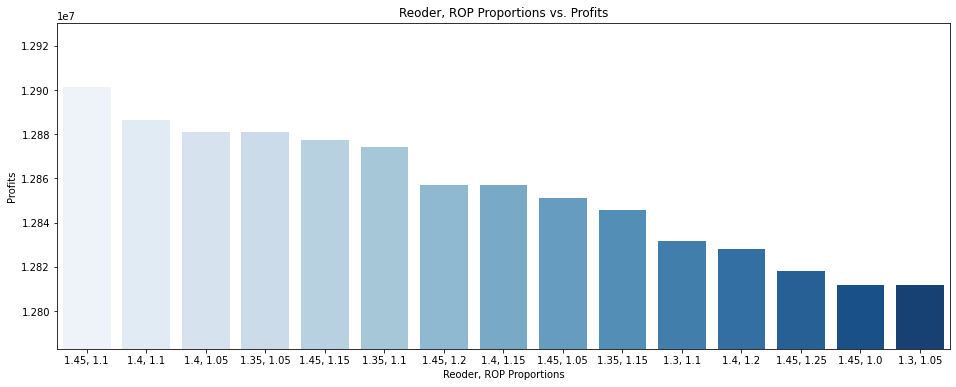

In [1336]:
plt.figure(figsize=(16,6))

filtered = agg[:15]

info = 'Profits'

sns.barplot(data=filtered, x='Reoder, ROP Proportions', y=info, palette='Blues')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Reoder, ROP Proportions vs. {}'.format(info))
plt.show()

plt.show()

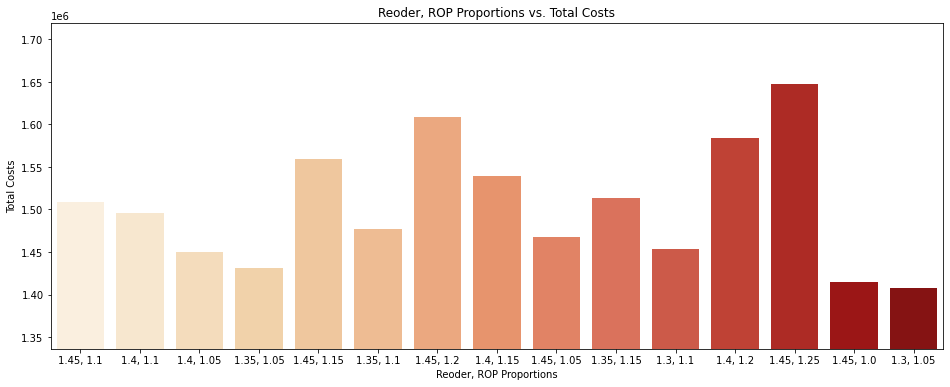

In [1337]:
plt.figure(figsize=(16,6))

filtered = agg[:15]

info = 'Total Costs'

sns.barplot(data=filtered, x='Reoder, ROP Proportions', y=info, palette='OrRd')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Reoder, ROP Proportions vs. {}'.format(info))
plt.show()

plt.show()

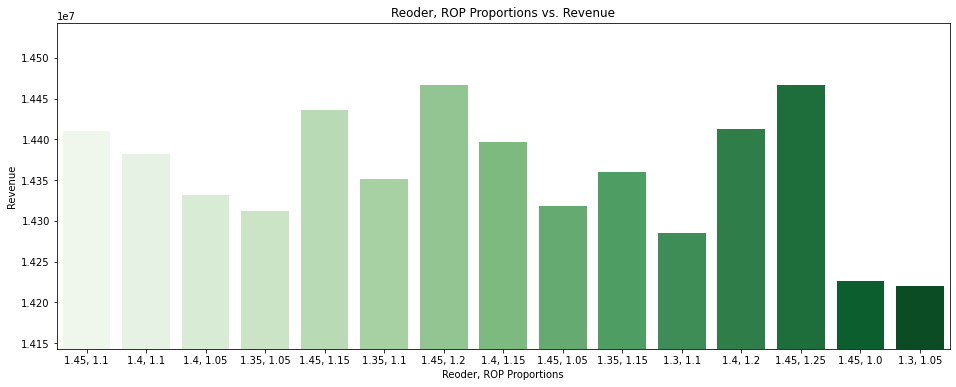

In [1340]:
plt.figure(figsize=(16,6))

filtered = agg[:15]

info = 'Revenue'

sns.barplot(data=filtered, x='Reoder, ROP Proportions', y=info, palette='Greens')
plt.ylim(filtered[info].min()-filtered[info].std(), filtered[info].max()+filtered[info].std())

plt.title('Reoder, ROP Proportions vs. {}'.format(info))
plt.show()

plt.show()